In [1]:
import numpy as np
import healpy as hp
from astropy.io import fits
import emcee as mcmc
import matplotlib.pyplot as plt
import matplotlib
import corner as corner
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

### Define all input variables.

In [57]:
Freq=[50.0, 78.0, 119.0,  195.0, 235.0, 337.0]#...............Frequency channels considered
Fwhm_arcmin=[56.0, 39.0, 25.0, 20.0, 29.0, 20.0]#.............Beam resolution for corresponding frequency channel
i=5

nu_GHz=Freq[i]
fwhm_arcmin=Fwhm_arcmin[i]

fwhm_rad=np.deg2rad(fwhm_arcmin/60)#..........................Beam resolution in radians

nside=512;
npix=hp.nside2npix(nside);
lmax=2*nside;
lmin=2;

# Bools to select whether to include foregrounds and noise. Also whether to consider half of noise amplitude.

fg=True
noise=True
half_noise=False
if half_noise==True:
    coeff_n=0.5
else:
    coeff_n=1.0
smooth_FG=True

alpha=[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0];#................Input miscalibration angles in degrees
n=len(alpha)
theta_cmb=np.deg2rad(alpha);#.................................Input miscalibration angles in radians
N=7#..........................................................Smoothing window length (need to be odd for correct estimation with this code!!!!!)3

## Input the appropriate CMB, foreground and noise map and theoretical CMB power spectra of E-mode and B-mode.
### The foreground map is converted to gaussian foreground map by taking only the features of the map as dictated by statistics upto the 2nd order, i.e., the power spectrum. The power spectrum is also smoothed before converting back to map.

In [3]:
map_file_cmb="Instrument_cmb_{}GHz_map.fits".format(nu_GHz)
map_CMB=hp.read_map(map_file_cmb,field=(0,1,2))

if fg==True:
    map_file_fg="Instrument_foreground_{}GHz_map.fits".format(nu_GHz)
    map_FG_original=hp.read_map(map_file_fg,field=(0,1,2))#.........................................Read the foreground simulated map
    if smooth_FG==True:
        FG_cl=hp.anafast(map_FG_original,lmax=lmax)#................................................Take its power spectrum
        FG_cl_smooth=np.empty(FG_cl.shape)
        for i in range(FG_cl.shape[0]):
            FG_cl_pad=np.pad(FG_cl[i,:],(N//2, N-1-N//2), mode='edge')#.............................Padding the edges of the aray so thal FG_cl and FG_cl_smooth has same length
            FG_cl_smooth[i,:]=np.convolve(FG_cl_pad, np.ones((N,))/N, mode='valid')#................Moving average/smoothing using convolution
        map_FG=hp.synfast(FG_cl_smooth,nside=nside,lmax=lmax)#......................................Generating a gaussian foreground map with the smoothed power spectrum
    else:
        map_FG=map_FG_original

if noise==True:
    map_file_noise="Instrument_noise_{}GHz_map.fits".format(nu_GHz)
    map_Noise=hp.read_map(map_file_noise,field=(0,1,2))
else:
    map_Noise=np.zeros(map_CMB.shape)
    
cmb_th_cl_EE,cmb_th_cl_BB=hp.read_cl("Instrument_theory_spectrum.fits")[1:3,lmin:lmax+1]
nmaps=hp.maptype(map_CMB)

### Perform the rotation by $\alpha$ for the CMB and foreground maps, specifically the Q and U components (2nd and 3rd columns).

\begin{equation}
\begin{pmatrix}
Q_{rotated} \\
U_{rotated} 
\end{pmatrix}=
\begin{pmatrix}
cos(2\alpha) & -sin(2\alpha) \\
sin(2\alpha) & cos(2\alpha) 
\end{pmatrix}
\begin{pmatrix}
Q \\
U 
\end{pmatrix}
\end{equation}

In [4]:
map_rot_CMB=np.empty([nmaps,npix,n])

if fg==True:
    map_rot_FG=np.empty([nmaps,npix,n])
else:
    map_rot_FG=np.zeros(map_CMB.shape)

for i in range(n):
    cmb_rot_matrix=np.array([[np.cos(2.0*theta_cmb[i]), -1.0*np.sin(2.0*theta_cmb[i])],#....................Rotation matrix
                             [np.sin(2.0*theta_cmb[i]),  np.cos(2.0*theta_cmb[i])]])
    map_rot_CMB[0,:,i]=map_CMB[0,:]#........................................................................I component is not rotated
    map_rot_CMB[1,:,i],map_rot_CMB[2,:,i]=np.dot(cmb_rot_matrix,np.array([map_CMB[1,:],map_CMB[2,:]]))#.....Q and U are rotated
    
    if fg==True:
        fg_rot_matrix=cmb_rot_matrix#.......................................................................When no birefringence, CMB and FG are rotated by same angle.
        map_rot_FG[0,:,i]=map_FG[0,:]
        map_rot_FG[1,:,i],map_rot_FG[2,:,i]=np.dot(fg_rot_matrix,np.array([map_FG[1,:],map_FG[2,:]]))

## Coadd the rotated CMB, foreground and noise maps to get simulated full sky signals into I, Q and U maps.

In [5]:
Sky_map_I=np.empty([npix,n])
Sky_map_Q=np.empty([npix,n])
Sky_map_U=np.empty([npix,n])
for i in range(n):
    Sky_map_I[:,i]=map_rot_CMB[0,:,i]+map_rot_FG[0,:,i]+coeff_n*map_Noise[0,:]
    Sky_map_Q[:,i]=map_rot_CMB[1,:,i]+map_rot_FG[1,:,i]+coeff_n*map_Noise[1,:]
    Sky_map_U[:,i]=map_rot_CMB[2,:,i]+map_rot_FG[2,:,i]+coeff_n*map_Noise[2,:]

### Convert the I, Q and U maps to the six power spectra in spherical harmonic domain.
Also define the beam function to be multiplied to the theoretical power spectra of CMB. The signal taken as input already has the beam incorporated during simulation.

Cl_EE_O, Cl_BB_O, and Cl_EB_O are required for the log likelihood. 'O' denotes that these arrays are observed values. 

In [6]:
Cl_EE_O=np.empty([lmax-lmin+1,n])
Cl_BB_O=np.empty([lmax-lmin+1,n])
Cl_EB_O=np.empty([lmax-lmin+1,n])
for i in range(n):
    cl=hp.anafast(np.array([Sky_map_I[:,i],Sky_map_Q[:,i],Sky_map_U[:,i]]),lmax=lmax)# ....the output order is TT, EE, BB, TE, EB, TB

    Cl_EE_O[:,i]=cl[1,lmin:lmax+1]
    Cl_BB_O[:,i]=cl[2,lmin:lmax+1]
    Cl_EB_O[:,i]=cl[4,lmin:lmax+1]

b_l_E=hp.gauss_beam(fwhm_rad,lmax=lmax, pol=True)[lmin:,1]#.................................b_l_E is same as b_l_B. So, just taking b_l_E

## Define the log Likelihood function  as per https://arxiv.org/abs/1904.12440.

## $ln(L)~=~-\frac{1}{2}\sum_{l=2}^{l_{max}}~\frac{\big[C_l^{EB,O}~-~\frac{tan(4\alpha)}{2}(C_l^{EE,O}-C_l^{BB,O})~-~\frac{sin(4\beta)}{2cos(4\alpha)}(C_l^{EE,CMB,th}-C_l^{BB,CMB,th})b_l^2\big]^2}{\frac{1}{2l+1}~\big[ C_l^{EE,O}C_l^{BB,O}~+~\frac{tan(4\alpha)^2}{2}(\{C_l^{EE,O}\}^2+\{C_l^{BB,O}\}^2)~-~2tan(4\alpha)C_l^{EB,O}(C_l^{EE,O}-C_l^{BB,O}) \big]}$

Define the terms required for the Likelihood function.

In [7]:
def get_terms(Cl_EE_O,Cl_BB_O,Cl_EB_O,cmb_th_cl_EE,cmb_th_cl_BB,b_l_E):
    # 1. Cl_EB_O 
    Num_1=Cl_EB_O

    # 2. (Cl_EE_O - Cl_BB_O)
    Num_2=Cl_EE_O-Cl_BB_O

    # 3. (Cl_EE_CMB_th - Cl_BB_CMB_th)*(b_l_E/B)^2
    Num_3=(cmb_th_cl_EE-cmb_th_cl_BB)*b_l_E*b_l_E

    # 4. Cl_EE_O * Cl_BB_O
    Denom_1=Cl_EE_O*Cl_BB_O

    # 5. (Cl_EE_O)^2 + (Cl_BB_O)^2
    Denom_2=(Cl_EE_O**2)+(Cl_BB_O**2)

    # 6. Cl_EB_O*(Cl_EE_O - Cl_BB_O)
    Denom_3=Num_1*Num_2
    
    cl_terms=[Num_1, Num_2, Num_3, Denom_1, Denom_2, Denom_3]
    
    return cl_terms

Now, define log likelihood with only $\alpha$ as a parameter and value of $\beta$ set to zero.

In [8]:
def log_L(param,cl_terms):
    
    alpha=param
    beta=0.0#.............................................Beta set to zero as it is not estimated
    Alpha=np.deg2rad(alpha)#..............................Convert parameter to radian as we are plotting the parameters in degrees.
    Beta=np.deg2rad(beta)
    
    l=np.arange(lmin,lmax+1)
    l_=1.0/(2.0*l+1)
    
    tan_a=np.tan(4.0*Alpha)
    cos_a=np.cos(4.0*Alpha)
    sin_b=np.sin(4.0*Beta)
    
    Coeff_num_2=(-0.5)*tan_a
    Coeff_num_3=(-0.5)*(sin_b/cos_a)
    Coeff_denom_2=(0.5)*tan_a*tan_a
    Coeff_denom_3=(-2.0)*tan_a
    
    Num1,Num2,Num3,Denom1,Denom2,Denom3=cl_terms
    
    return (-0.5)*np.sum(np.square(Num1 + Coeff_num_2*Num2 + Coeff_num_3*Num3)/(l_*(Denom1 + Coeff_denom_2*Denom2 + Coeff_denom_3*Denom3)))

Set an approximate range of the parameter $\alpha$ to define the prior and limit the parameter space. In degrees. Since we are considering values from -3 to 3 degree, the limit [-4,4] makes sense.

In [9]:
param_min=-4.0*np.ones(n)#[x-1 for x in alpha]#
param_max=4.0*np.ones(n)#[x+1 for x in alpha]#

### Define flat priors and get the posterior distribution to use instead of log_L. Define the posterior as (prior x likelihood) => log_posterior = log_prior + log_likelihood.

In [10]:
def log_prior(param,param_min,param_max):
    if not param_min < param < param_max:
        log_prob=-np.inf#............................If the sample is not within the range, probability is put to 0
    else:
        log_prob=0.0#................................If the sample is within the range, the prioir probability is 1
    return log_prob

In [11]:
def log_posterior(param,cl_terms,param_min,param_max):
    lp=log_prior(param,param_min,param_max)
    if np.isfinite(lp):
        return lp + log_L(param,cl_terms)#...........log_posterior = log_prior + log_likelihood if the prior is finite
    return -np.inf

## Define the arguments needed to run emcee MCMC estimation of $\alpha$ and run the sampler.

In [12]:
ndim, nwalkers = 1, 100
niter = 10000
#np.random.seed(123)

### Run the sampler

The initating point is taken such that it will have a uniform spread over the whole range of parameter values. 

Minimum value + (spread of values) * (random numbers between 0 and 1) => random numbers between minimum value and maximum value

In [13]:
sampler_all=[]
sampler_flat=[]
thin, discard = 1, 100
for i in range(n):
    p0 = param_min[i]+ (param_max[i]-param_min[i])*np.random.rand(nwalkers)#............Make sure the starting points are within the expected range -> easier convergence.
    #p0 = np.random.normal(alpha[i],1.0,size=nwalkers)
    p0 = p0.reshape((p0.shape[0],1))#...................................................To make the array initiating-points the right dimension to input into the run_mcmc function
    
    cl_terms=get_terms(Cl_EE_O[:,i],Cl_BB_O[:,i],Cl_EB_O[:,i],cmb_th_cl_EE,cmb_th_cl_BB,b_l_E)
    
    sampler = mcmc.EnsembleSampler(nwalkers, ndim, log_posterior, args=[cl_terms,param_min[i],param_max[i]])
    sampler.run_mcmc(p0, niter, progress=True);
    
    sampler_all.append(sampler.get_chain(thin=thin, discard=discard)[:, :, 0])
    sampler_flat.append(sampler.get_chain(thin=thin, discard=discard,flat=True))
    #print(np.mean(sampler.acceptance_fraction))

 14%|█▍        | 1428/10000 [00:09<01:02, 136.86it/s]<ipython-input-8-84d5b11f5888>:22: RuntimeWarning: divide by zero encountered in true_divide
  return (-0.5)*np.sum(np.square(Num1 + Coeff_num_2*Num2 + Coeff_num_3*Num3)/(l_*(Denom1 + Coeff_denom_2*Denom2 + Coeff_denom_3*Denom3)))
100%|██████████| 10000/10000 [00:45<00:00, 221.65it/s]


### Plot the normal and corner plot of the result.

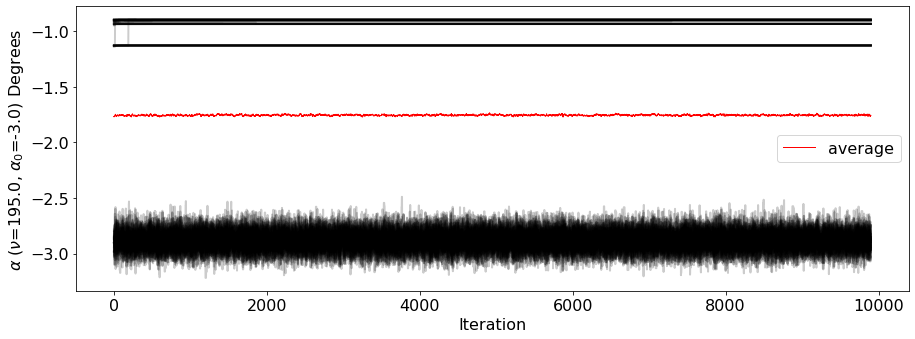

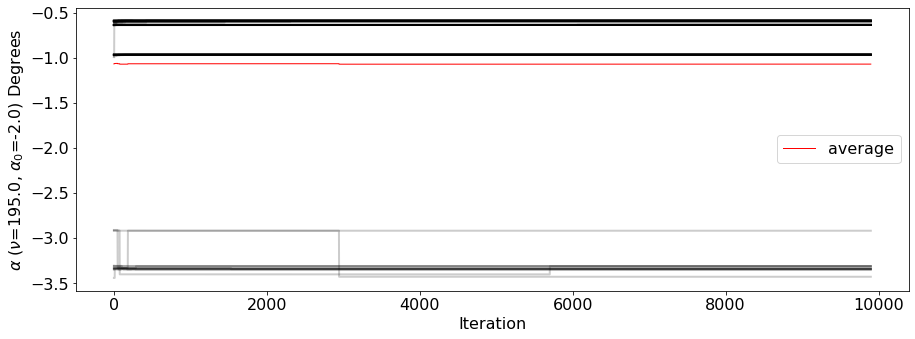

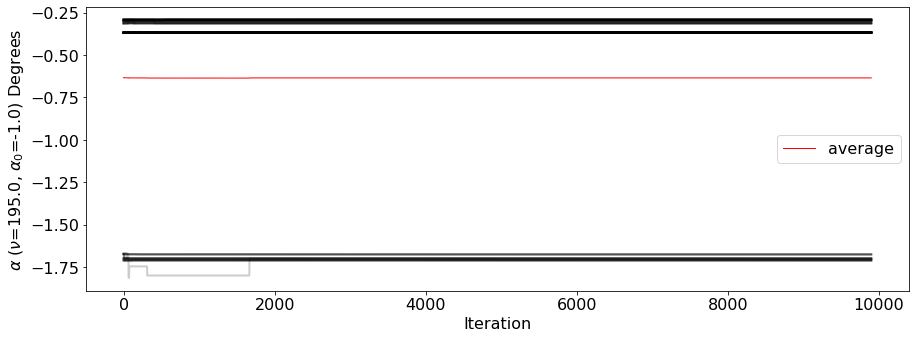

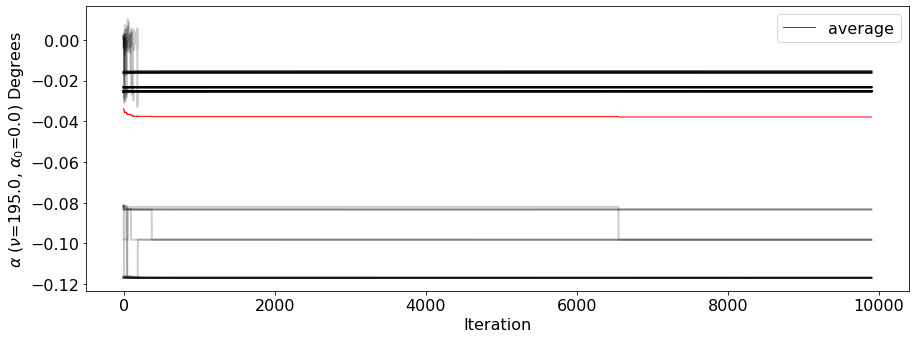

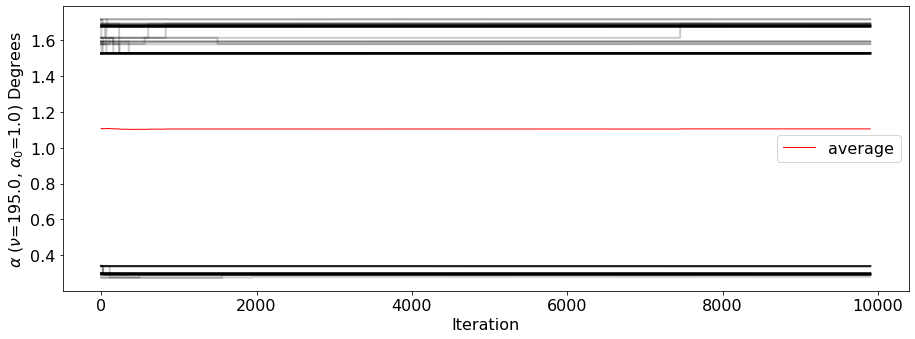

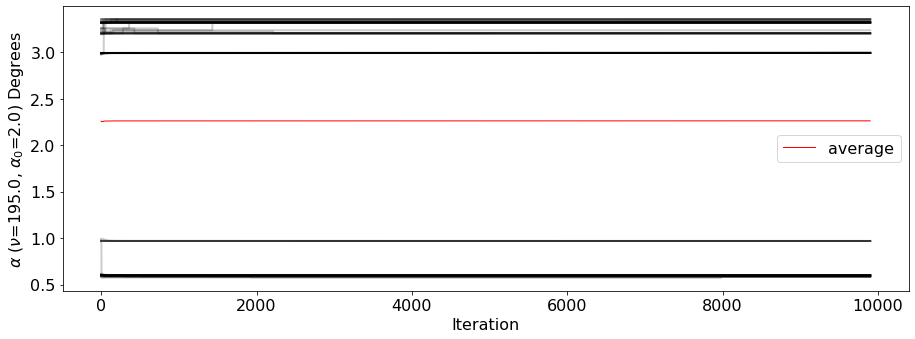

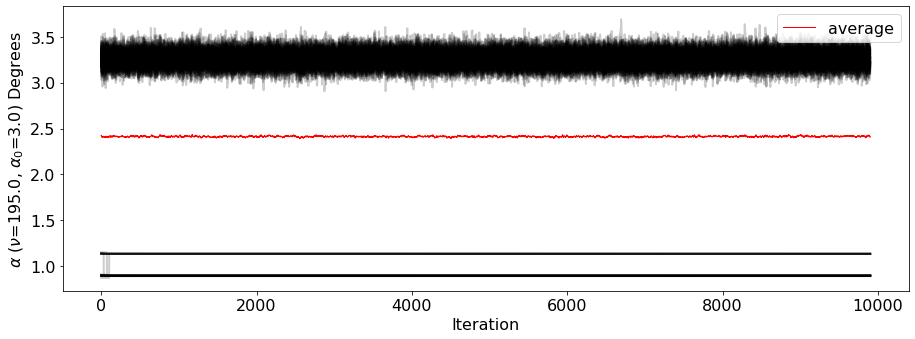

In [15]:
for i in range(n):
    param_name = r'$\alpha$ '+r'($\nu$={}, $\alpha_0$={})'.format(nu_GHz,alpha[i])+' Degrees'#.................The r is required for the latex commands to be recognized
    
    plt.figure(figsize=(13, 5))
    plt.plot(sampler_all[i], color='black', alpha=0.2, lw=2)#..................................................The array has dim [niter-discard, nwalkers, ndim]
    plt.plot(np.average(sampler_all[i],axis=1), color='r', alpha=1, lw=1, label="average")#....................Plotting average over all walkers
    plt.xlabel('Iteration')
    plt.ylabel(param_name)
    plt.tight_layout()
    plt.legend()

<Figure size 1080x360 with 0 Axes>

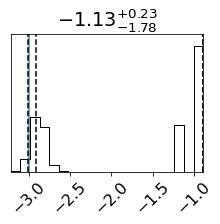

<Figure size 1080x360 with 0 Axes>

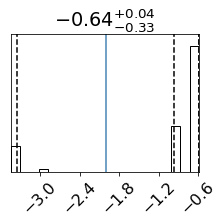

<Figure size 1080x360 with 0 Axes>

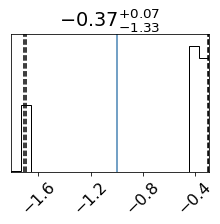

<Figure size 1080x360 with 0 Axes>

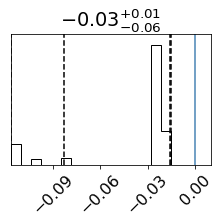

<Figure size 1080x360 with 0 Axes>

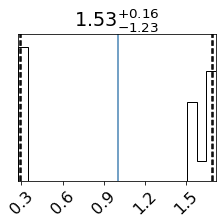

<Figure size 1080x360 with 0 Axes>

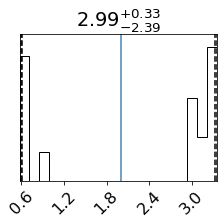

<Figure size 1080x360 with 0 Axes>

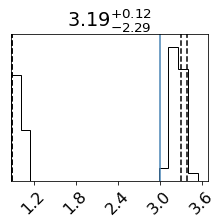

In [16]:
for i in range(n):
    plt.figure(figsize=(15,5))
    fig=corner.corner(sampler_flat[i], quantiles=(0.025,0.16, 0.84,0.975), show_titles=True,truths=[alpha[i]]);
    plt.tight_layout()

### Get the 1-$\sigma$ errorbars and plot out the output/estimated value against input value.

1-sigma:  [-1.7809942590940233, 0.22911689163004234]
alpha estimate (alpha_in = -3.0)=  -1.1265414919912424

1-sigma:  [-0.329617637793159, 0.04447097763297114]
alpha estimate (alpha_in = -2.0)=  -0.6375189729642157

1-sigma:  [-1.3322040244280393, 0.071453082601653]
alpha estimate (alpha_in = -1.0)=  -0.36749960078643285

1-sigma:  [-0.05813974199183873, 0.009083158684481948]
alpha estimate (alpha_in = 0.0)=  -0.025183515754985304

1-sigma:  [-1.2342213536427855, 0.15575083770996923]
alpha estimate (alpha_in = 1.0)=  1.527516911145994

1-sigma:  [-2.39047467089627, 0.3296604173251536]
alpha estimate (alpha_in = 2.0)=  2.992057375759135

1-sigma:  [-2.293398044894497, 0.11876905919273062]
alpha estimate (alpha_in = 3.0)=  3.1922356336405535



Text(2, -3, '195.0 GHz')

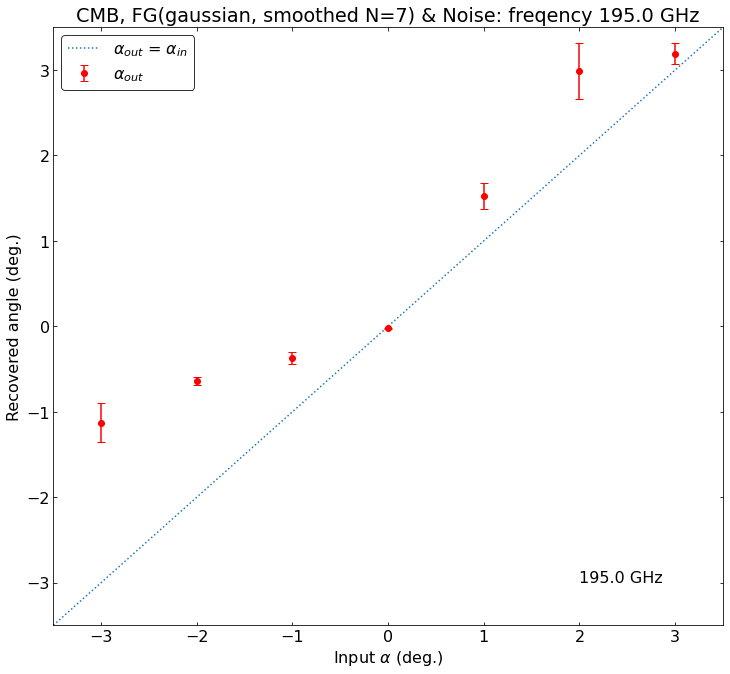

In [17]:
err=[]
alpha_out=[]

if fg!=True and noise!=True:
    title='Only CMB: freqency {} GHz'.format(nu_GHz)
elif fg==True and noise!=True:
    title='CMB & FG(gaussian): freqency {} GHz'.format(nu_GHz)
elif fg!=True and noise==True:
    title='CMB & Noise: freqency {} GHz'.format(nu_GHz)
else:
    title='CMB, FG(gaussian, smoothed N={}) & Noise: freqency {} GHz'.format(N,nu_GHz)
if half_noise==True:
    title+=': 0.5*Noise'
    
plt.figure(figsize=(12, 11))
x=np.linspace(-3.5,3.5,100)
plt.plot(x,x,':')
plt.title(title.format(nu_GHz))
plt.xlabel(r'Input $\alpha$ (deg.)')
plt.ylabel(r'Recovered angle (deg.)')

for i in range(n):
    q_16, q_50, q_84 = corner.quantile(sampler_flat[i], [0.16, 0.5, 0.84])#................................Quantiles to get one-sigma values and the mean
    one_sigma_down, one_sigma_up = q_16-q_50, q_84-q_50#...................................................One-sigma values to plot the error bar
    alpha_estimate=q_50#...................................................................................Mean is the estimate/output
    print('1-sigma: ',[one_sigma_down, one_sigma_up])
    print("alpha estimate (alpha_in = {})= ".format(alpha[i]),alpha_estimate)
    print("")
    
    plt.errorbar(alpha[i],alpha_estimate,fmt='ro',yerr=one_sigma_up,capsize=4)
    
    err.append(one_sigma_up)
    alpha_out.append(alpha_estimate)
    
#x=np.linspace(np.min(param_min),np.max(param_max),100)
plt.tick_params(axis='both', which='both',direction='in',top=True,bottom=True,left=True,right=True)
plt.xlim([-3.5,3.5])
plt.ylim([-3.5,3.5])
plt.legend([r'$\alpha_{out}$ = $\alpha_{in}$',r'$\alpha_{out}$'],edgecolor="black")
plt.text(2, -3, '{} GHz'.format(nu_GHz))

### Also, plot the difference of output and inputa value along with the error bar at 0.

Text(0, 0.5, 'Error')

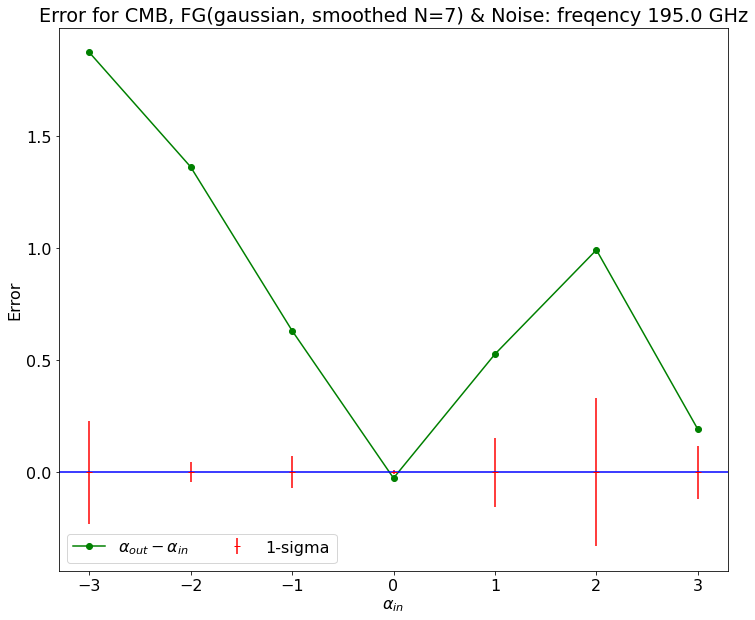

In [18]:
plt.figure(figsize=(12, 10))
plt.errorbar(alpha,np.zeros(n),fmt='r_',yerr=err,label='1-sigma')
plt.plot(alpha,np.array(alpha_out)-np.array(alpha),'go-',label=r'$\alpha_{out}-\alpha_{in}$')
plt.axhline(y = 0.0, color = 'b', linestyle = '-')
plt.legend(loc='lower left', ncol=2)
plt.title("Error for "+title)
plt.xlabel(r'$\alpha_{in}$')
plt.ylabel("Error")

In [19]:
err

[0.22911689163004234,
 0.04447097763297114,
 0.071453082601653,
 0.009083158684481948,
 0.15575083770996923,
 0.3296604173251536,
 0.11876905919273062]

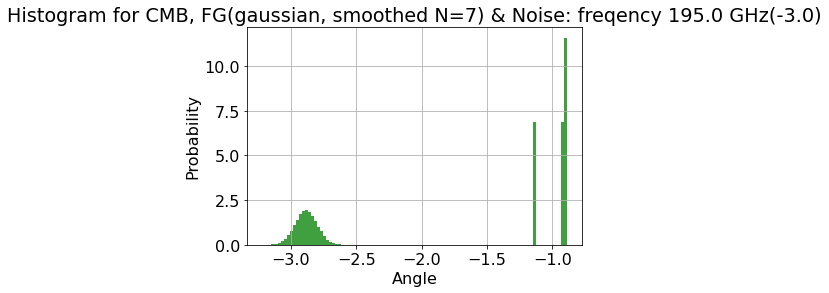

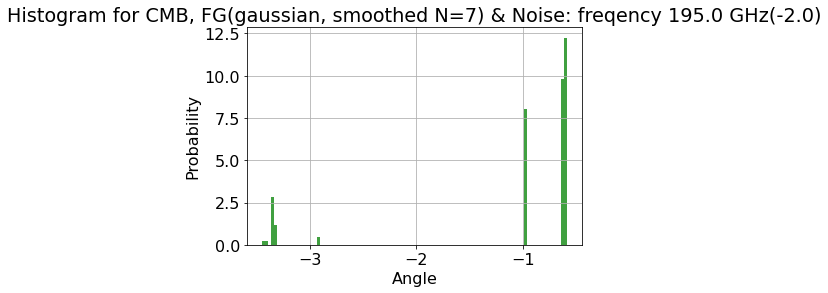

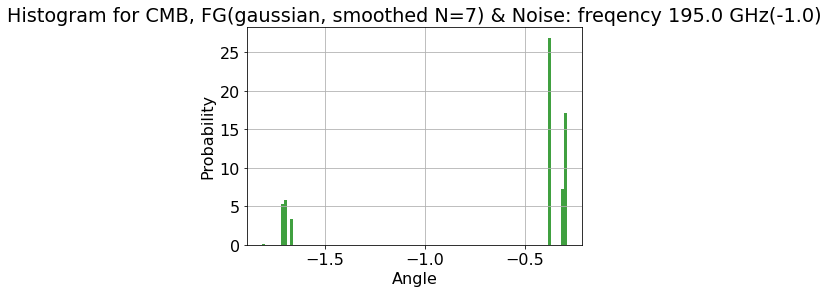

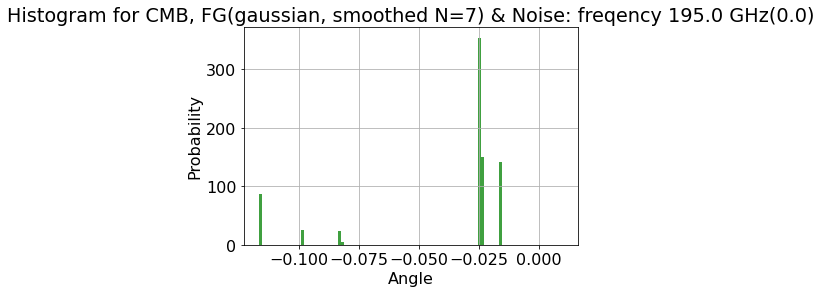

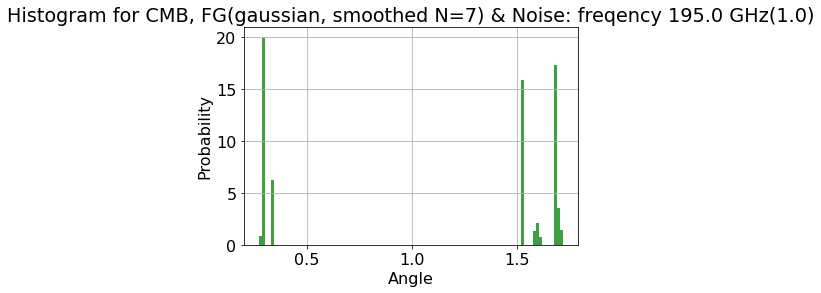

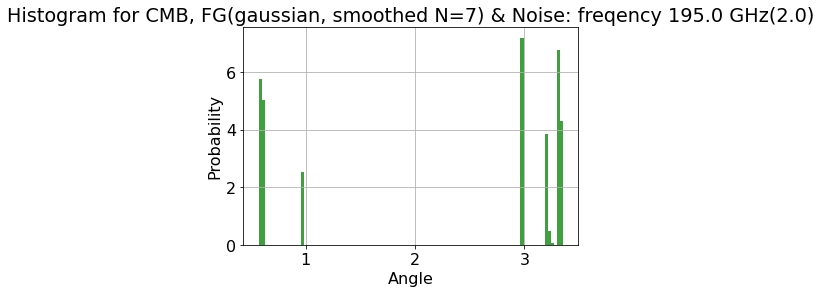

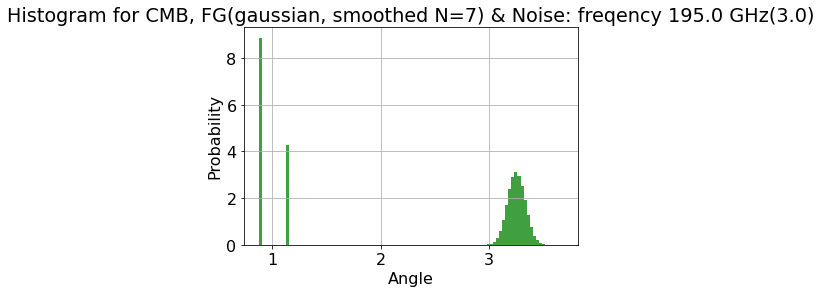

In [83]:
for i in range(n):
    plt.figure(i)
    plt.hist(sampler_flat[i], 100, density=True, facecolor='g', alpha=0.75)
    #cl_terms=get_terms(Cl_EE_O[:,i],Cl_BB_O[:,i],Cl_EB_O[:,i],cmb_th_cl_EE,cmb_th_cl_BB,b_l_E)
    #prob=np.exp(log_L(alpha[i],cl_terms))
    #plt.plot(alpha[i],prob,'ro')

    plt.xlabel('Angle')
    plt.ylabel('Probability')
    plt.title("Histogram for "+title+"({})".format(alpha[i]))
    #plt.xlim(40, 160)
    #plt.ylim(0, 0.03)
    plt.grid(True)

In [41]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

i=4
for i in range(n):
    cl_terms=get_terms(Cl_EE_O[:,i],Cl_BB_O[:,i],Cl_EB_O[:,i],cmb_th_cl_EE,cmb_th_cl_BB,b_l_E)
    alpha_=alpha[i]

    #np.random.seed(42)
    nll = lambda *args: -log_L(*args)
    bounds=Bounds(-180.0,180.0)
    initial = np.array(alpha_) + 0.1 * np.random.randn(1)
    soln = minimize(nll, initial, args=(cl_terms),bounds=bounds)
    alpha_ml = soln.x
    x0 = np.linspace(0, 10, 500)

    #A = np.vander(x, 2)
    #C = np.diag(yerr * yerr)
    #ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
    #cov = np.linalg.inv(ATA)
    #w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))

    print("Maximum likelihood estimate for alpha_in={} :".format(alpha_))
    print("alpha = {}".format(alpha_ml))
    print("")
    #print("beta = {0:.3f}".format(beta_ml))


Maximum likelihood estimate for alpha_in=-3.0 :
alpha = [-2.88736198]

Maximum likelihood estimate for alpha_in=-2.0 :
alpha = [-1.59263262]

Maximum likelihood estimate for alpha_in=-1.0 :
alpha = [43.32806709]

Maximum likelihood estimate for alpha_in=0.0 :
alpha = [-0.0254164]

Maximum likelihood estimate for alpha_in=1.0 :
alpha = [1.71749257]

Maximum likelihood estimate for alpha_in=2.0 :
alpha = [3.3308041]

Maximum likelihood estimate for alpha_in=3.0 :
alpha = [3.25725283]

